# Deep Dreams (with Caffe)

This notebook demonstrates how to use the [Caffe](http://caffe.berkeleyvision.org/) neural network framework to produce "dream" visuals shown in the [Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with **#deepdream** so other researchers can check them out too.

##Dependencies
This notebook is designed to have as few dependencies as possible:
* Standard Python scientific stack: [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), [PIL](http://www.pythonware.com/products/pil/), [IPython](http://ipython.org/). Those libraries can also be installed as a part of one of the scientific packages for Python, such as [Anaconda](http://continuum.io/downloads) or [Canopy](https://store.enthought.com/).
* [Caffe](http://caffe.berkeleyvision.org/) deep learning framework ([installation instructions](http://caffe.berkeleyvision.org/installation.html)).
* Google [protobuf](https://developers.google.com/protocol-buffers/) library that is used for Caffe model manipulation.

In [2]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

## Loading DNN model
In this notebook we are going to use a [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particularly interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [3]:
#model_path = 'models/googlenet_places365/' # substitute your path here
#net_fn   = model_path + 'deploy.prototxt'
#param_fn = model_path + 'googlenet_places365.caffemodel'


model_path = 'models/jcaffe/may16/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'may16.caffemodel'





# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [4]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='pool2', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

Next we implement an ascent through different scales. We call these scales "octaves".

In [5]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='pool5', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

Now we are ready to let the neural network reveal its dreams! Let's take a [cloud image](https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG) as a starting point:

In [5]:
! locate main.py

/notebooks/AI-music-Compose/main.py
/usr/lib/python2.7/lib2to3/main.py
/usr/lib/python2.7/lib2to3/main.pyc
/usr/lib/python2.7/unittest/main.py
/usr/lib/python2.7/unittest/main.pyc
/usr/local/lib/python2.7/dist-packages/pbr/cmd/main.py
/usr/local/lib/python2.7/dist-packages/pbr/cmd/main.pyc
/usr/share/glib-2.0/codegen/codegen_main.py
/usr/share/glib-2.0/codegen/codegen_main.pyc


#   IMG_NOISE      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        IMG_NOISE

http://www.labri.fr/perso/nrougier/teaching/numpy.100/

In [16]:
!pip install sklearn

    100% |################################| 11.7MB 47kB/s eta 0:00:01
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /root/.cache/pip/wheels/d7/db/a3/1b8041ab0be63b5c96c503df8e757cf205c2848cf9ef55f85e
Successfully built sklearn


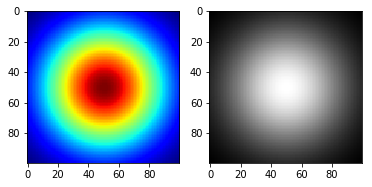

In [31]:
X, Y = np.ogrid[-5:5:0.1, -5:5:0.1]
R = np.exp(-(X**2 + Y**2) / 15)

fig, (ax_jet, ax_gray) = plt.subplots(1, 2)
ax_jet.imshow(R, cmap='jet')
ax_gray.imshow(R, cmap='gray');
plt.imshow(R, cmap='gray', interpolation='nearest');

In [21]:
import matplotlib.pyplot as mpl
import numpy as np
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
c1 = np.random.rand(100,2)+5
c2 = np.random.rand(50,2)
c3 = np.column_stack([u1,u2])

data= np.column_stack([c1,c2,c3])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [24]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(740,740,3)) + 200.0
#img_noise = np.random.rand(size=(740,740,3)) + 100.0

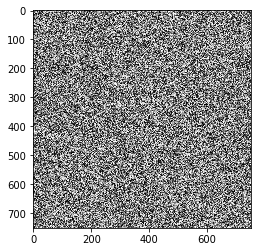

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

random_image = np.random.random([750, 750])

plt.imshow(random_image, cmap='gray', interpolation='nearest');
plt.savefig('noise.png')

In [65]:
#converts a grayscale into a usable uplad for a dram image
from PIL import Image
import glob, os

size = 1040, 1040, 3

for infile in glob.glob("specral.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".jpg", "JPEG")

In [66]:
!ls *.jpg

1.jpg	 2.jpg	 cropped_panda.jpg		       outnoise.jpg  test__.jpg
112.jpg  68.jpg  ed880500c80a307364be6d1f42c5b1dc.jpg  specral.jpg
113.jpg  90.jpg  noise_.jpg			       test_.jpg


In [45]:
from PIL import Image

image = Image.open('noise.png')
image = image.convert('RGB')
image = image.resize((200, 150), Image.ANTIALIAS)
image = image.convert('P', palette=Image.ADAPTIVE, colors=256)
image = image.convert('L', palette=Image.ADAPTIVE, colors=256)
image.save('outnoise.png')

('Linear0:', dtype('float64'), 0.0, 1.0)
('Linear1:', dtype('uint8'), 0, 255)


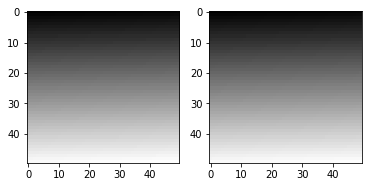

In [27]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

linear0 = np.linspace(0, 1, 2500).reshape((50, 50))
linear1 = np.linspace(0, 255, 2500).reshape((50, 50)).astype(np.uint8)

print("Linear0:", linear0.dtype, linear0.min(), linear0.max())
print("Linear1:", linear1.dtype, linear1.min(), linear1.max())

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(linear0, cmap='gray')
ax1.imshow(linear1, cmap='gray');


In [38]:
from PIL import Image
import numpy as np


def alpha_to_color(image, color=(255, 255, 255)):
    """Set all fully transparent pixels of an RGBA image to the specified color.
    This is a very simple solution that might leave over some ugly edges, due
    to semi-transparent areas. You should use alpha_composite_with color instead.

    Source: http://stackoverflow.com/a/9166671/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """ 
    x = np.array(image)
    r, g, b, a = np.rollaxis(x, axis=-1)
    r[a == 0] = color[0]
    g[a == 0] = color[1]
    b[a == 0] = color[2] 
    x = np.dstack([r, g, b, a])
    return Image.fromarray(x, 'RGBA')


def alpha_composite(front, back):
    """Alpha composite two RGBA images.

    Source: http://stackoverflow.com/a/9166671/284318

    Keyword Arguments:
    front -- PIL RGBA Image object
    back -- PIL RGBA Image object

    """
    front = np.asarray(front)
    back = np.asarray(back)
    result = np.empty(front.shape, dtype='float')
    alpha = np.index_exp[:, :, 3:]
    rgb = np.index_exp[:, :, :3]
    falpha = front[alpha] / 255.0
    balpha = back[alpha] / 255.0
    result[alpha] = falpha + balpha * (1 - falpha)
    old_setting = np.seterr(invalid='ignore')
    result[rgb] = (front[rgb] * falpha + back[rgb] * balpha * (1 - falpha)) / result[alpha]
    np.seterr(**old_setting)
    result[alpha] *= 255
    np.clip(result, 0, 255)
    # astype('uint8') maps np.nan and np.inf to 0
    result = result.astype('uint8')
    result = Image.fromarray(result, 'RGBA')
    return result


def alpha_composite_with_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA image with a single color image of the
    specified color and the same size as the original image.

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    back = Image.new('RGBA', size=image.size, color=color + (255,))
    return alpha_composite(image, back)


def pure_pil_alpha_to_color_v1(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    NOTE: This version is much slower than the
    alpha_composite_with_color solution. Use it only if
    numpy is not available.

    Source: http://stackoverflow.com/a/9168169/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """ 
    def blend_value(back, front, a):
        return (front * a + back * (255 - a)) / 255

    def blend_rgba(back, front):
        result = [blend_value(back[i], front[i], front[3]) for i in (0, 1, 2)]
        return tuple(result + [255])

    im = image.copy()  # don't edit the reference directly
    p = im.load()  # load pixel array
    for y in range(im.size[1]):
        for x in range(im.size[0]):
            p[x, y] = blend_rgba(color + (255,), p[x, y])

    return im

def pure_pil_alpha_to_color_v2(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Simpler, faster version than the solutions above.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background

In [39]:
newJPG = alpha_to_color("noise.png", color=(255, 255, 255))

ValueError: 'axis' arg requires 0 <= axis < 0, but -1 was passed in

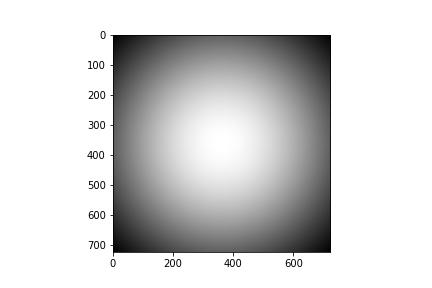

In [17]:
img = np.float32(PIL.Image.open('test.png'))
showarray(img)

In [76]:
from PIL import Image
img = Image.open('specral.jpg')
dim = (1000, 1000)
newimg = img.resize(dim)
# save the new image to a new filename
newimg.save('specral__.jpg')
import PIL.Image
from IPython.display import clear_output, Image, display

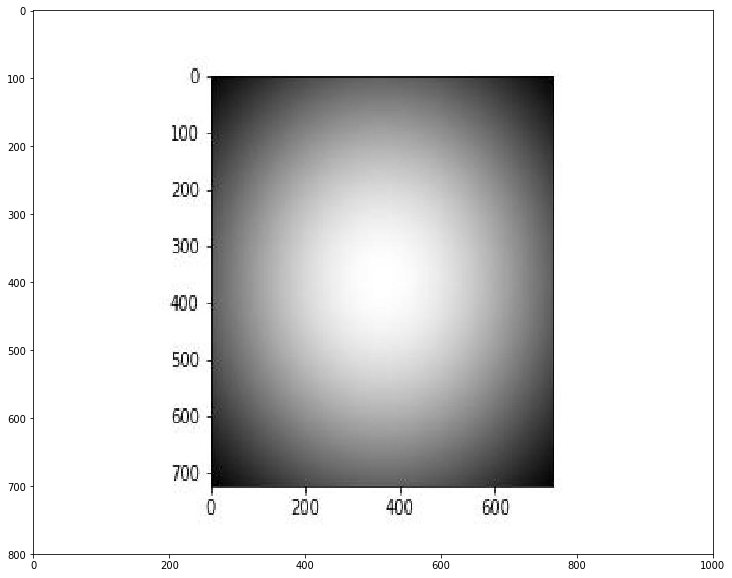

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('test__.jpg')
imgplot = plt.imshow(img)
#img = np.float32(PIL.Image.open('test_.jpg'))
#showarray(img)

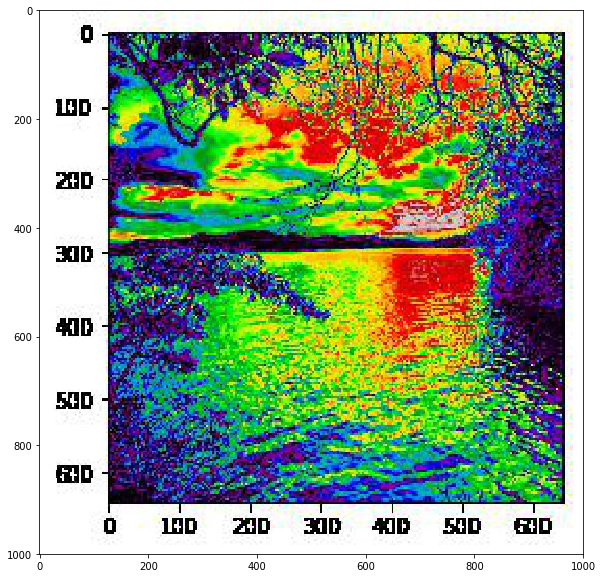

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('specral__.jpg')
imgplot = plt.imshow(img)
#img = np.float32(PIL.Image.open('test_.jpg'))
#showarray(img)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

In [8]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(740,740,3)) + 100.0


In [1]:
#_=deepdream(net, img_noise, iter_n=20, octave_n=8, end='conv4')
_=deepdream(net, img, end='conv4')

NameError: name 'deepdream' is not defined

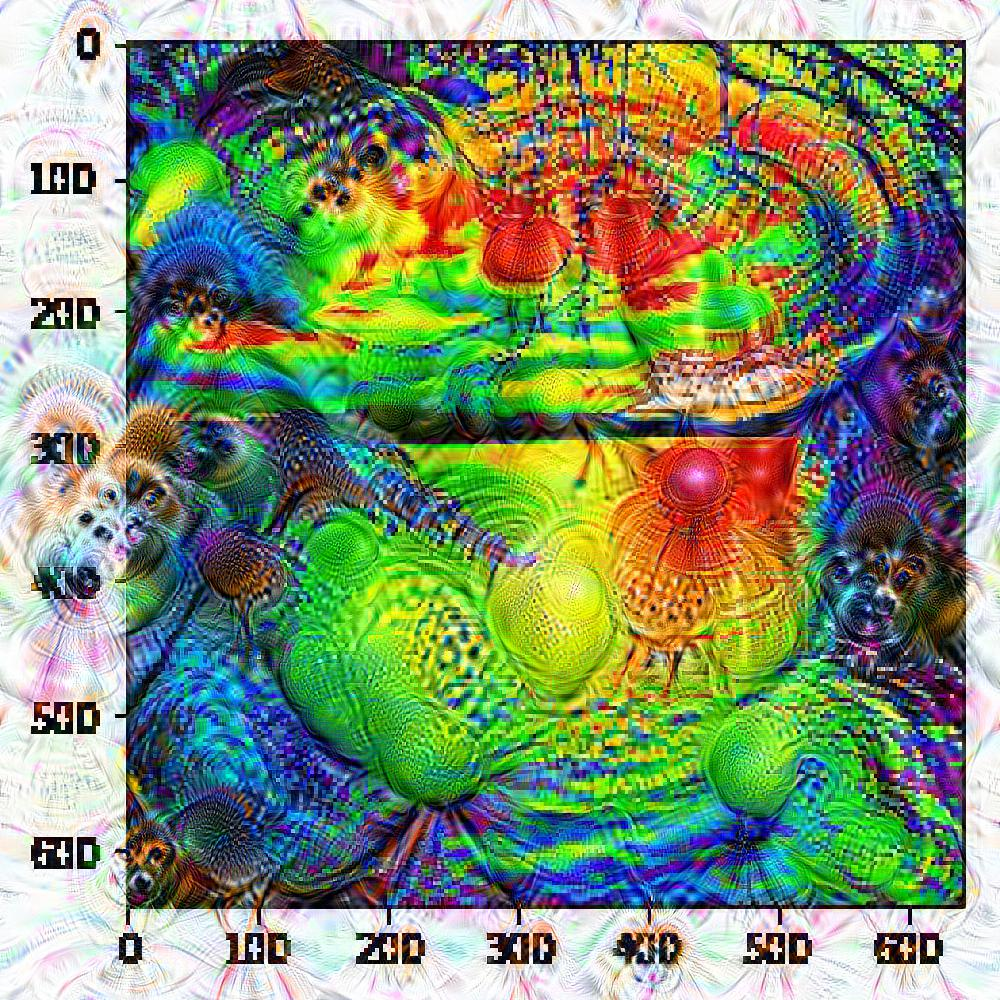

7 19 pool5 (1000, 1000, 3)


In [7]:
_=deepdream(net, img, iter_n=20, octave_n=8, end='pool5')

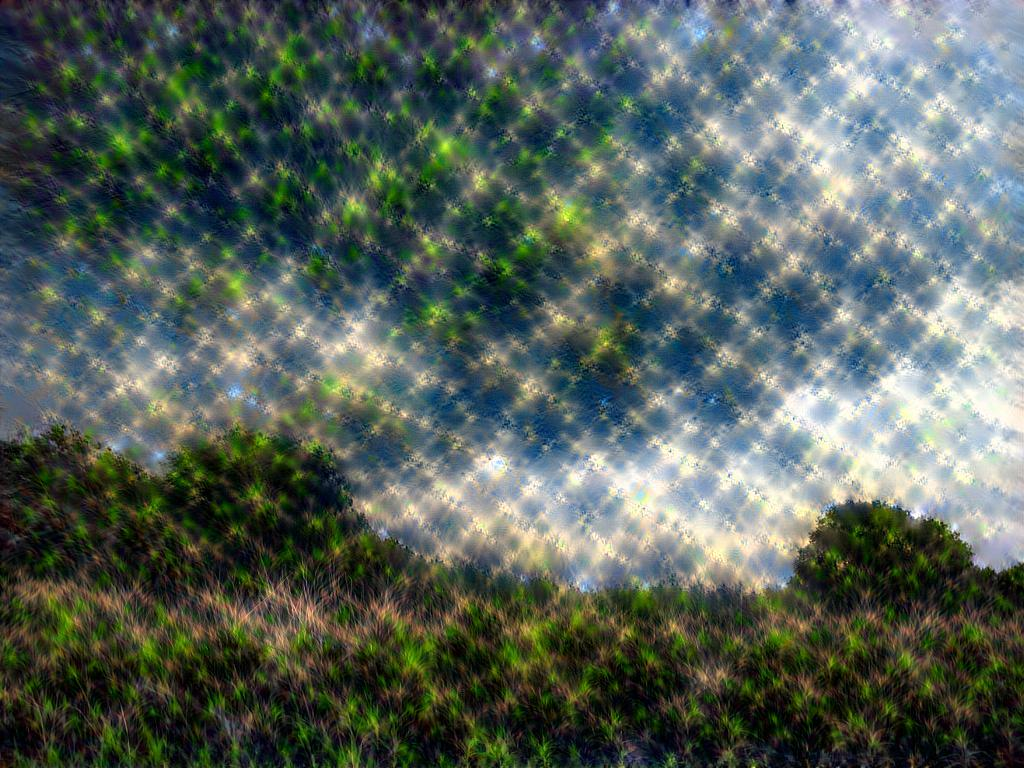

7 19 conv5 (768, 1024, 3)


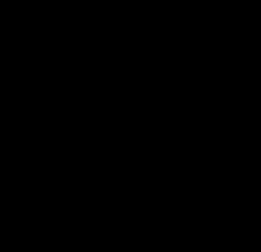

7 19 pool5 (252, 261, 3)


In [74]:
_=deepdream(net, img, iter_n=20, octave_n=8)

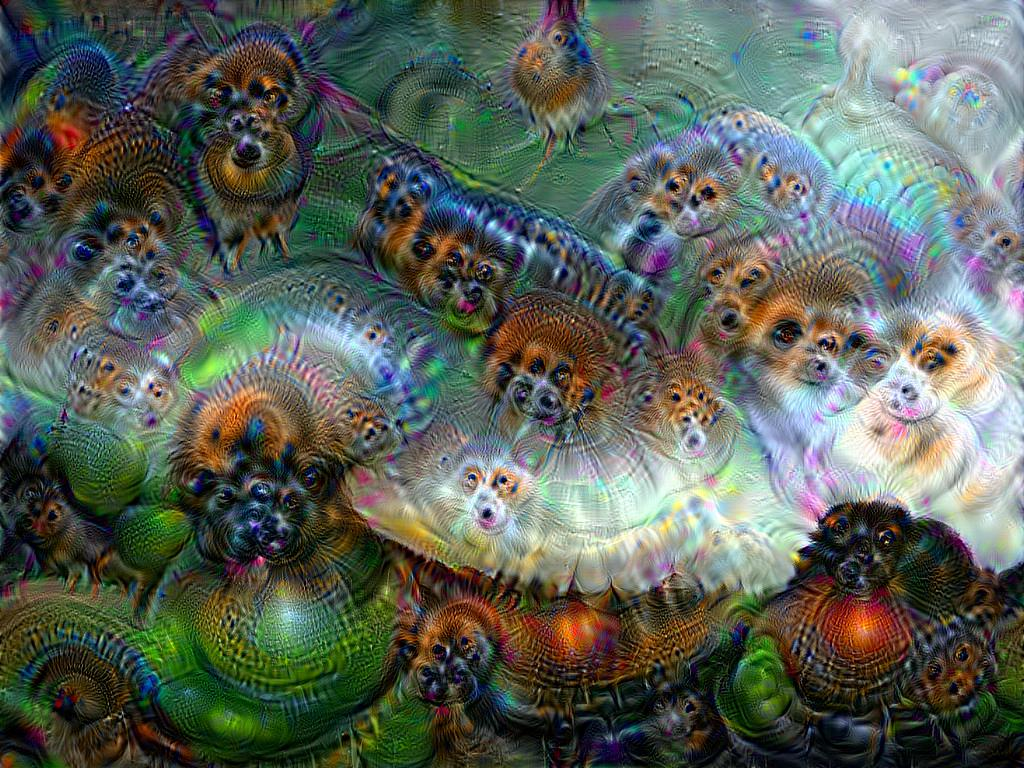

7 19 pool5 (768, 1024, 3)


In [9]:
_=deepdream(net, img, iter_n=20, octave_n=8)

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

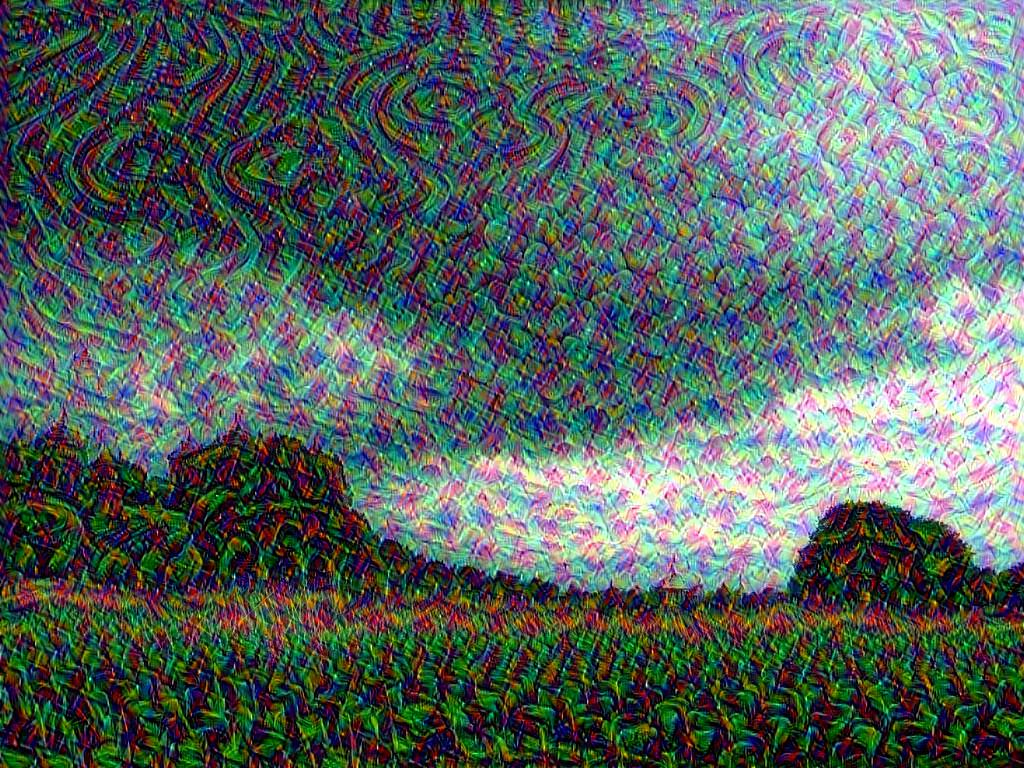

3 9 norm1 (768, 1024, 3)


In [11]:
_=deepdream(net, img, end='norm1')

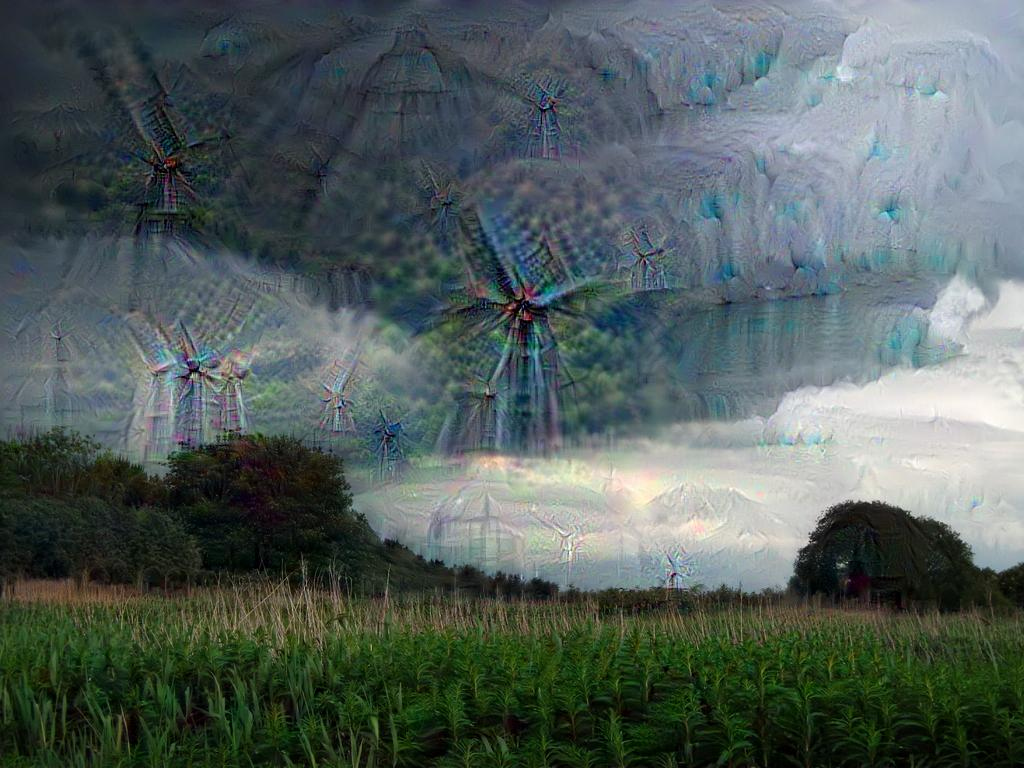

7 2 inception_5b/pool_proj (768, 1024, 3)


In [13]:
test = deepdream(net, _, iter_n=3, jitter=5, octave_n=8, end='inception_5b/pool_proj')

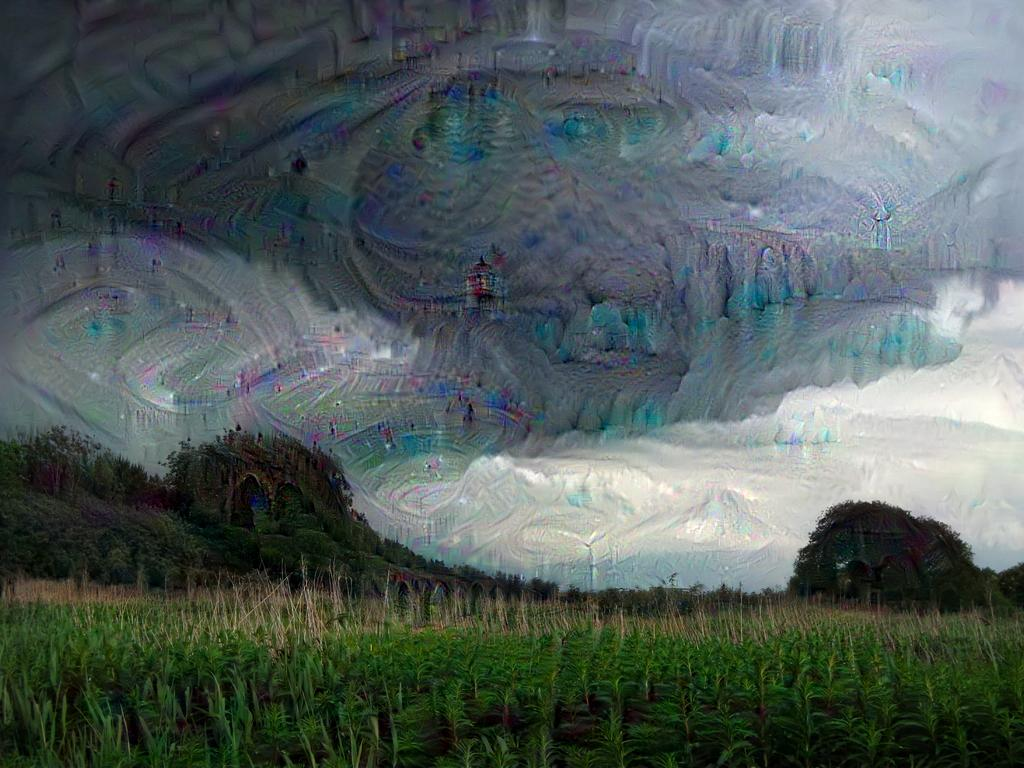

7 2 inception_5b/pool_proj (768, 1024, 3)


In [12]:
test = deepdream(net, img, iter_n=3, octave_n=8, end='inception_5b/pool_proj')

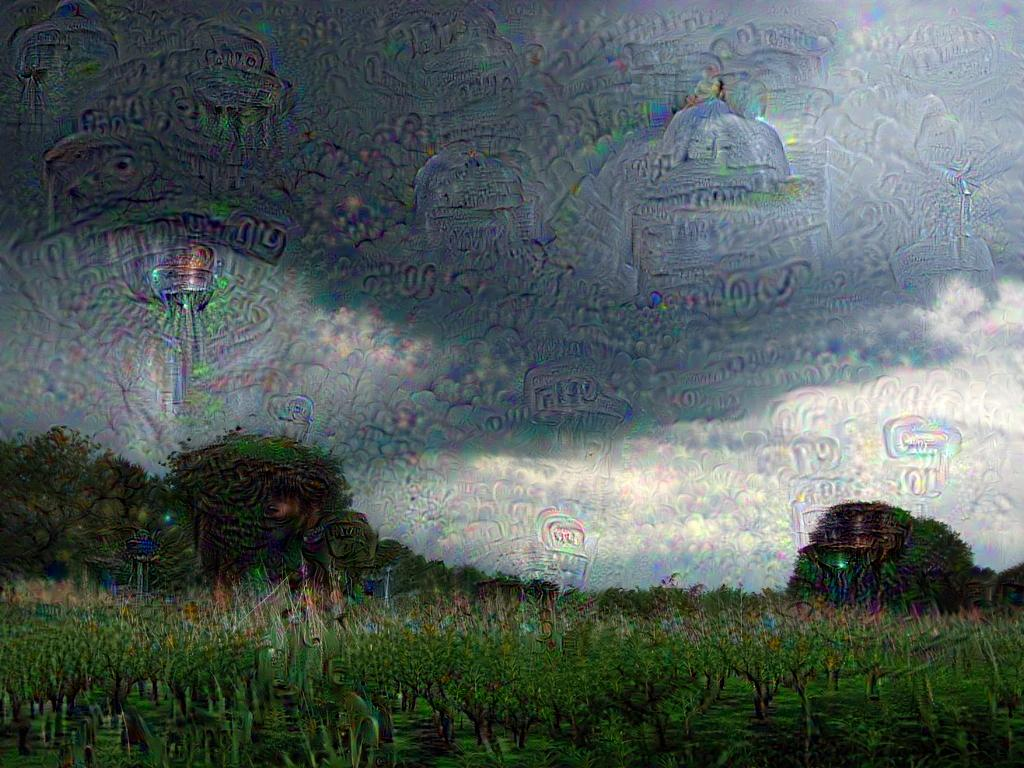

3 9 inception_5b/output (768, 1024, 3)


In [10]:
_=deepdream(net, img, end='inception_5b/output')

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

In [11]:
net.blobs.keys()

['data',
 'conv1',
 'pool1',
 'norm1',
 'conv2',
 'pool2',
 'norm2',
 'conv3',
 'conv4',
 'conv5',
 'pool5',
 'fc6',
 'fc7',
 'fc8_ft',
 'prob']

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

In [55]:
!mkdir p5CAFFE_DREAM
frame = img
frame_i = 0

mkdir: cannot create directory 'p5CAFFE_DREAM': File exists


In [53]:
h, w = frame.shape[:2]
s = 0.1 # scale coefficient
for i in xrange(75):
    frame = deepdream(net, frame, iter_n=15, octave_n=8, end='pool5')
    PIL.Image.fromarray(np.uint8(frame)).save("p5CAFFE_DREAM/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

IOError: [Errno 2] No such file or directory: 'p5CAFFE_DREAM/0000.jpg'

Be careful running the code above, it can bring you into very strange realms!

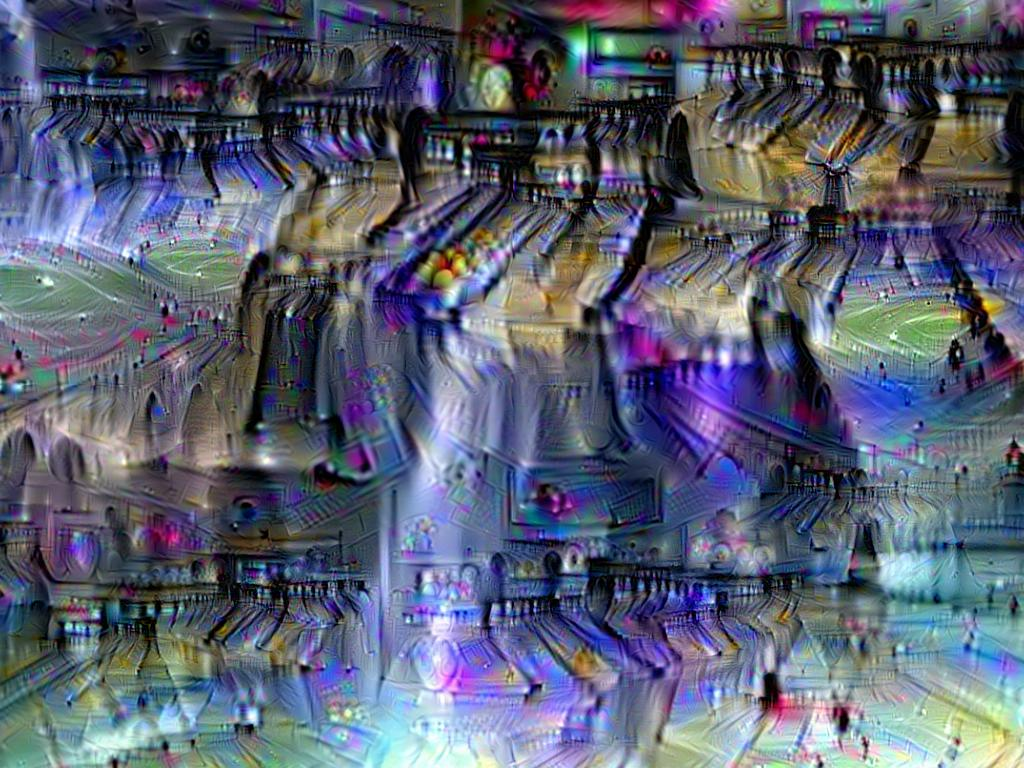

In [16]:
Image(filename='CAFFE_DREAM/0029.jpg')

## Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "*guide*".

In [19]:
!ls bugs/clockfaces/thumbs

In [10]:
!ls jpg

10.jpg	 121.jpg  141.jpg  153.jpg  171.jpg  31.jpg  56.jpg  72.jpg  91.jpg
100.jpg  122.jpg  143.jpg  154.jpg  173.jpg  35.jpg  57.jpg  73.jpg  92.jpg
104.jpg  126.jpg  145.jpg  155.jpg  174.jpg  36.jpg  58.jpg  75.jpg  94.jpg
108.jpg  127.jpg  147.jpg  157.jpg  179.jpg  42.jpg  6.jpg   78.jpg  95.jpg
109.jpg  13.jpg   148.jpg  158.jpg  2.jpg    44.jpg  61.jpg  8.jpg
11.jpg	 131.jpg  149.jpg  159.jpg  20.jpg   46.jpg  63.jpg  80.jpg
111.jpg  132.jpg  15.jpg   160.jpg  22.jpg   49.jpg  64.jpg  83.jpg
116.jpg  133.jpg  150.jpg  161.jpg  24.jpg   5.jpg   66.jpg  84.jpg
117.jpg  135.jpg  151.jpg  166.jpg  27.jpg   51.jpg  7.jpg   87.jpg
120.jpg  136.jpg  152.jpg  167.jpg  30.jpg   55.jpg  71.jpg  9.jpg


Note that the neural network we use was trained on images downscaled to 224x224 size. So high resolution images might have to be downscaled, so that the network could pick up their features. The image we use here is already small enough.

Now we pick some target layer and extract guide image features.

In [21]:
end = 'pool5'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

In [23]:
showarray(guide_features)

TypeError: Cannot handle this data type

print (guide_features)

Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their best matching correspondences from the guide image.

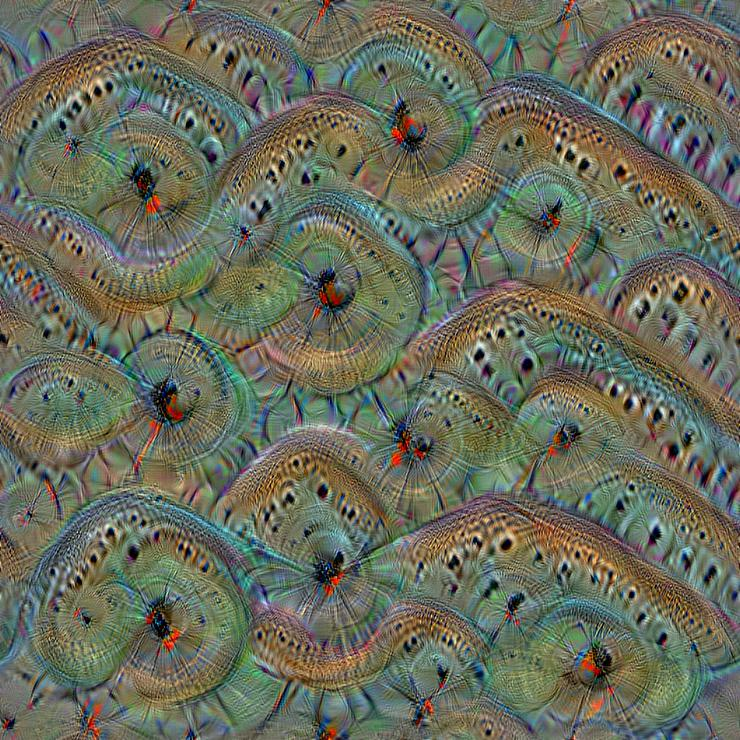

3 49 pool5 (740, 740, 3)


In [24]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

_=deepdream(net, img_noise, iter_n=50,end=end, objective=objective_guide)

# Guide Experiment

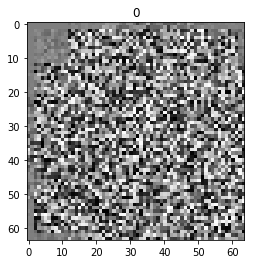

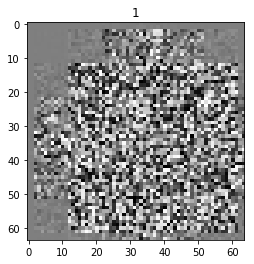

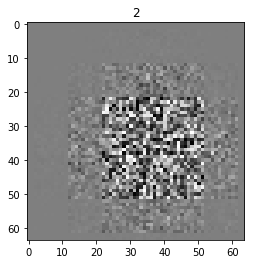

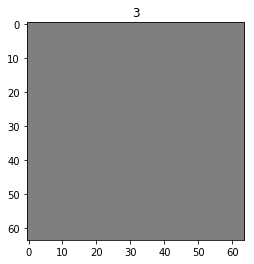

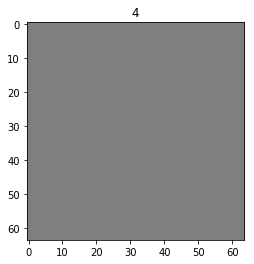

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def gauss2D(shape,sx=1,sy=1):
    """
    unnormalized 2D gauss centered on mean value, 
    given shape and standard dev (sx and sy).
    """
    mx = shape[0]/2
    my = shape[1]/2

    return np.exp( -0.5*(
        ((np.arange(shape[0])[:,None]-mx)/sx)**2+
        ((np.arange(shape[0])[None,:]-my)/sy)**2
        ))#/(2*np.pi*sx*sy)

width,height = 740,740
my_img = np.zeros((width,height,3))+0.9
fig = plt.figure()
ax = fig.gca()
N=5
for i in range(N):
    my_img[:,:,:]=0.5 #gray bg image
    w = N*100/(4**(2*i))
    A = (1-.1*(i+1))
    noise =A*np.random.normal(0,w,(width,height))*gauss2D((width,height),10,10)
    plt.imshow(my_img+noise[:,:,None]) #noise affects rgb equally
    plt.title(i)
    plt.show()

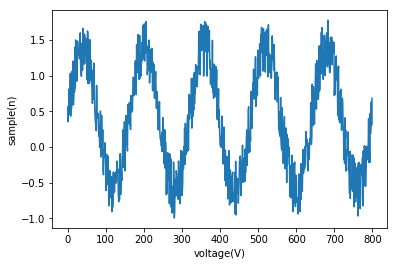

In [55]:
    import matplotlib.pyplot as plt
    import numpy as np
    import random
     
    Fs = 800
    f = 5
    sample = 800
    x = np.arange(sample)
    noise = 0.0008*np.asarray(random.sample(range(0,1000),sample))
     
    y = np.sin(2 * np.pi * f * x / Fs)+noise
    plt.plot(x, y)
    plt.xlabel('voltage(V)')
    plt.ylabel('sample(n)')
    plt.show()

In [39]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(740,740,3)) + 100.0

In [57]:
#All in One Guide Experiment
guide0 = np.float32(PIL.Image.open('bugs/spiders/thumbs/0028.png'))
end = 'pool5'
h, w = guide0.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide0)
net.forward(end=end)

guide_features0 = dst.data[0].copy()
def objective_guide0(dst):
    x = dst.data[0].copy()
    y = guide_features0
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best
#spider=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide0)
spider=deepdream(net, noise, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide0)

ValueError: 'axis' arg requires -1 <= axis < 1, but 2 was passed in

# Guide Experiment --END--

# guide 1

In [27]:
end = 'pool5'
h, w = guide2.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide2)
net.forward(end=end)
guide_features2 = dst.data[0].copy()

This way we can affect the style of generated images without using a different training set.

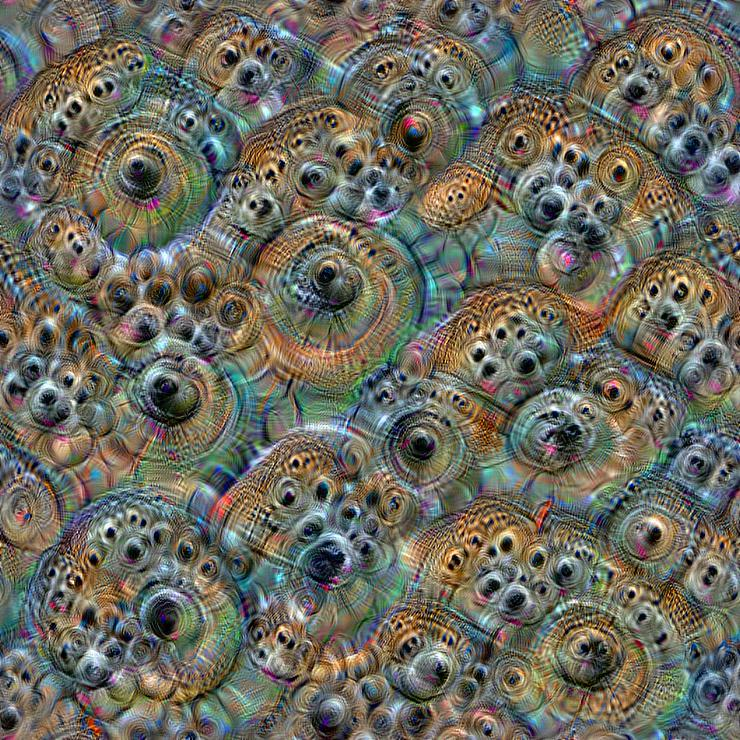

3 49 pool5 (740, 740, 3)


In [28]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features2
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

gear=deepdream(net, _, jitter=3, iter_n=50,end=end, ovtave_n=8, objective=objective_guide)

# guide 2

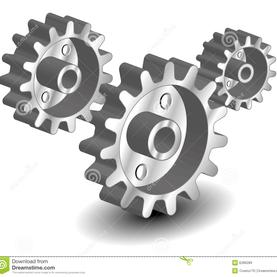

In [26]:
guide2 = np.float32(PIL.Image.open('bugs/gears/thumbs/gears_0066.png'))
showarray(guide2)

In [27]:
end = 'pool5'
h, w = guide2.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide2)
net.forward(end=end)
guide_features2 = dst.data[0].copy()

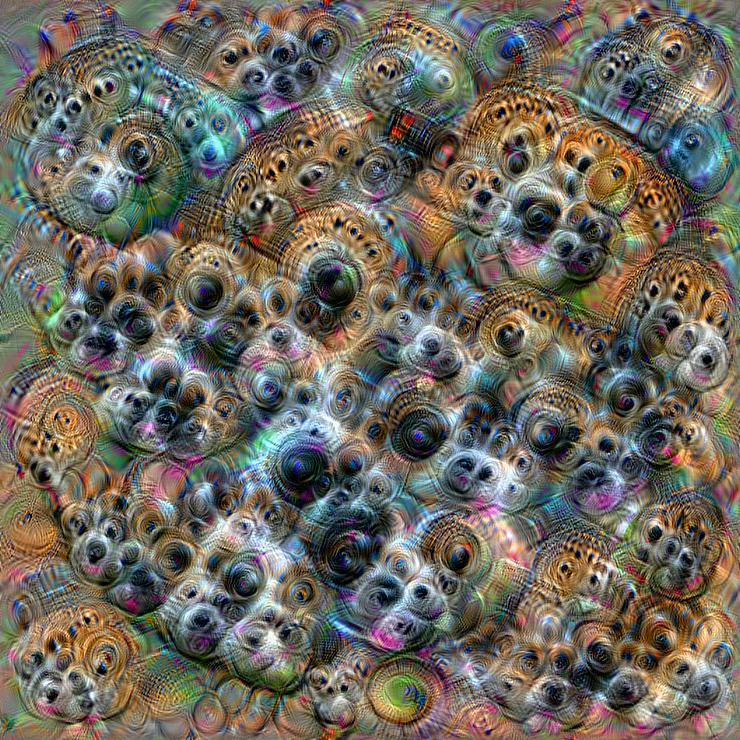

7 49 pool5 (740, 740, 3)


In [31]:
def objective_guide1(dst):
    x = dst.data[0].copy()
    y = guide_features2
    ch = x.shape[0]
    x = x.reshape(ch,-1)+2
    y = y.reshape(ch,-1)+2
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

gear=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide1)

# guide 3

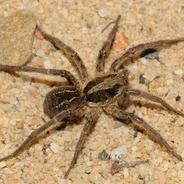

In [33]:
guide3 = np.float32(PIL.Image.open('bugs/spiders/thumbs/0028.png'))
showarray(guide3)

In [34]:
end = 'pool5'
h, w = guide3.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide3)
net.forward(end=end)
guide_features3 = dst.data[0].copy()

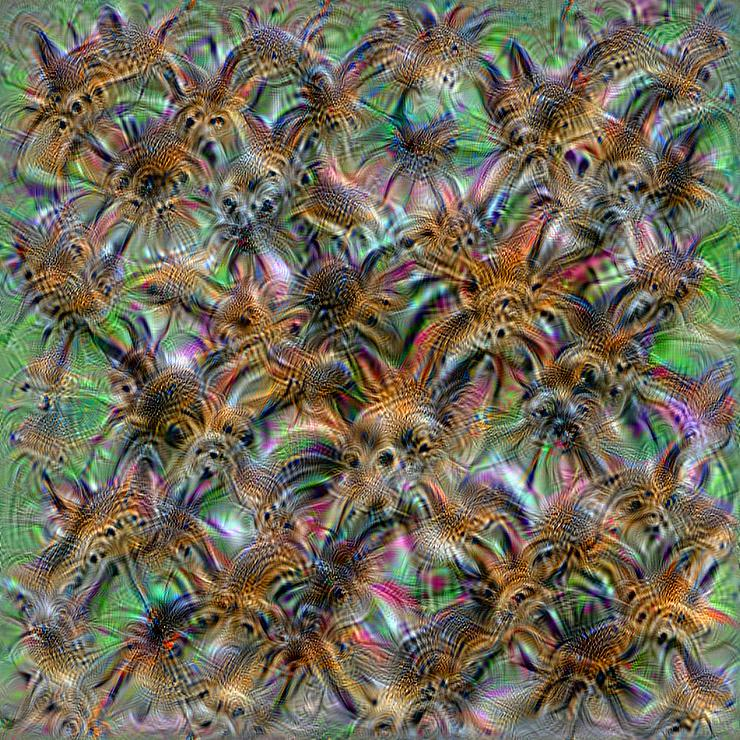

7 49 pool5 (740, 740, 3)


In [35]:
def objective_guide3(dst):
    x = dst.data[0].copy()
    y = guide_features3
    ch = x.shape[0]
    x = x.reshape(ch,-1)+2
    y = y.reshape(ch,-1)+2
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

spider=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide3)

# All in One Experiment

In [ ]:
#All in One Guide Experiment
guide3 = np.float32(PIL.Image.open('bugs/spiders/thumbs/0028.png'))
end = 'pool5'
h, w = guide3.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide3)
net.forward(end=end)
guide_features3 = dst.data[0].copy()
def objective_guide3(dst):
    x = dst.data[0].copy()
    y = guide_features3
    ch = x.shape[0]
    x = x.reshape(ch,-1)+2
    y = y.reshape(ch,-1)+2
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

spider=deepdream(net, _, jitter=3, iter_n=50,end=end, octave_n=8, objective=objective_guide3)

In [53]:
#Unknown result 
from PIL import Image

def get_white_noise_image(width, height):
    pil_map = Image.new("RGBA", (width, height), 255)
    random_grid = map(lambda x: (
            int(random.random() * 256),
            int(random.random() * 256),
            int(random.random() * 256)
        ), [0] * width * height)
    somenoise = pil_map.putdata(random_grid)
    return pil_map

In [ ]:
# %load /usr/lib/python2.7/unittest/main.py
"""Unittest main program"""

import sys
import os
import types

from . import loader, runner
from .signals import installHandler

__unittest = True

FAILFAST     = "  -f, --failfast   Stop on first failure\n"
CATCHBREAK   = "  -c, --catch      Catch control-C and display results\n"
BUFFEROUTPUT = "  -b, --buffer     Buffer stdout and stderr during test runs\n"

USAGE_AS_MAIN = """\
Usage: %(progName)s [options] [tests]

Options:
  -h, --help       Show this message
  -v, --verbose    Verbose output
  -q, --quiet      Minimal output
%(failfast)s%(catchbreak)s%(buffer)s
Examples:
  %(progName)s test_module               - run tests from test_module
  %(progName)s module.TestClass          - run tests from module.TestClass
  %(progName)s module.Class.test_method  - run specified test method

[tests] can be a list of any number of test modules, classes and test
methods.

Alternative Usage: %(progName)s discover [options]

Options:
  -v, --verbose    Verbose output
%(failfast)s%(catchbreak)s%(buffer)s  -s directory     Directory to start discovery ('.' default)
  -p pattern       Pattern to match test files ('test*.py' default)
  -t directory     Top level directory of project (default to
                   start directory)

For test discovery all test modules must be importable from the top
level directory of the project.
"""

USAGE_FROM_MODULE = """\
Usage: %(progName)s [options] [test] [...]

Options:
  -h, --help       Show this message
  -v, --verbose    Verbose output
  -q, --quiet      Minimal output
%(failfast)s%(catchbreak)s%(buffer)s
Examples:
  %(progName)s                               - run default set of tests
  %(progName)s MyTestSuite                   - run suite 'MyTestSuite'
  %(progName)s MyTestCase.testSomething      - run MyTestCase.testSomething
  %(progName)s MyTestCase                    - run all 'test*' test methods
                                               in MyTestCase
"""



class TestProgram(object):
    """A command-line program that runs a set of tests; this is primarily
       for making test modules conveniently executable.
    """
    USAGE = USAGE_FROM_MODULE

    # defaults for testing
    failfast = catchbreak = buffer = progName = None

    def __init__(self, module='__main__', defaultTest=None, argv=None,
                    testRunner=None, testLoader=loader.defaultTestLoader,
                    exit=True, verbosity=1, failfast=None, catchbreak=None,
                    buffer=None):
        if isinstance(module, basestring):
            self.module = __import__(module)
            for part in module.split('.')[1:]:
                self.module = getattr(self.module, part)
        else:
            self.module = module
        if argv is None:
            argv = sys.argv

        self.exit = exit
        self.failfast = failfast
        self.catchbreak = catchbreak
        self.verbosity = verbosity
        self.buffer = buffer
        self.defaultTest = defaultTest
        self.testRunner = testRunner
        self.testLoader = testLoader
        self.progName = os.path.basename(argv[0])
        self.parseArgs(argv)
        self.runTests()

    def usageExit(self, msg=None):
        if msg:
            print msg
        usage = {'progName': self.progName, 'catchbreak': '', 'failfast': '',
                 'buffer': ''}
        if self.failfast != False:
            usage['failfast'] = FAILFAST
        if self.catchbreak != False:
            usage['catchbreak'] = CATCHBREAK
        if self.buffer != False:
            usage['buffer'] = BUFFEROUTPUT
        print self.USAGE % usage
        sys.exit(2)

    def parseArgs(self, argv):
        if len(argv) > 1 and argv[1].lower() == 'discover':
            self._do_discovery(argv[2:])
            return

        import getopt
        long_opts = ['help', 'verbose', 'quiet', 'failfast', 'catch', 'buffer']
        try:
            options, args = getopt.getopt(argv[1:], 'hHvqfcb', long_opts)
            for opt, value in options:
                if opt in ('-h','-H','--help'):
                    self.usageExit()
                if opt in ('-q','--quiet'):
                    self.verbosity = 0
                if opt in ('-v','--verbose'):
                    self.verbosity = 2
                if opt in ('-f','--failfast'):
                    if self.failfast is None:
                        self.failfast = True
                    # Should this raise an exception if -f is not valid?
                if opt in ('-c','--catch'):
                    if self.catchbreak is None:
                        self.catchbreak = True
                    # Should this raise an exception if -c is not valid?
                if opt in ('-b','--buffer'):
                    if self.buffer is None:
                        self.buffer = True
                    # Should this raise an exception if -b is not valid?
            if len(args) == 0 and self.defaultTest is None:
                # createTests will load tests from self.module
                self.testNames = None
            elif len(args) > 0:
                self.testNames = args
                if __name__ == '__main__':
                    # to support python -m unittest ...
                    self.module = None
            else:
                self.testNames = (self.defaultTest,)
            self.createTests()
        except getopt.error, msg:
            self.usageExit(msg)

    def createTests(self):
        if self.testNames is None:
            self.test = self.testLoader.loadTestsFromModule(self.module)
        else:
            self.test = self.testLoader.loadTestsFromNames(self.testNames,
                                                           self.module)

    def _do_discovery(self, argv, Loader=None):
        if Loader is None:
            Loader = lambda: self.testLoader

        # handle command line args for test discovery
        self.progName = '%s discover' % self.progName
        import optparse
        parser = optparse.OptionParser()
        parser.prog = self.progName
        parser.add_option('-v', '--verbose', dest='verbose', default=False,
                          help='Verbose output', action='store_true')
        if self.failfast != False:
            parser.add_option('-f', '--failfast', dest='failfast', default=False,
                              help='Stop on first fail or error',
                              action='store_true')
        if self.catchbreak != False:
            parser.add_option('-c', '--catch', dest='catchbreak', default=False,
                              help='Catch Ctrl-C and display results so far',
                              action='store_true')
        if self.buffer != False:
            parser.add_option('-b', '--buffer', dest='buffer', default=False,
                              help='Buffer stdout and stderr during tests',
                              action='store_true')
        parser.add_option('-s', '--start-directory', dest='start', default='.',
                          help="Directory to start discovery ('.' default)")
        parser.add_option('-p', '--pattern', dest='pattern', default='test*.py',
                          help="Pattern to match tests ('test*.py' default)")
        parser.add_option('-t', '--top-level-directory', dest='top', default=None,
                          help='Top level directory of project (defaults to start directory)')

        options, args = parser.parse_args(argv)
        if len(args) > 3:
            self.usageExit()

        for name, value in zip(('start', 'pattern', 'top'), args):
            setattr(options, name, value)

        # only set options from the parsing here
        # if they weren't set explicitly in the constructor
        if self.failfast is None:
            self.failfast = options.failfast
        if self.catchbreak is None:
            self.catchbreak = options.catchbreak
        if self.buffer is None:
            self.buffer = options.buffer

        if options.verbose:
            self.verbosity = 2

        start_dir = options.start
        pattern = options.pattern
        top_level_dir = options.top

        loader = Loader()
        self.test = loader.discover(start_dir, pattern, top_level_dir)

    def runTests(self):
        if self.catchbreak:
            installHandler()
        if self.testRunner is None:
            self.testRunner = runner.TextTestRunner
        if isinstance(self.testRunner, (type, types.ClassType)):
            try:
                testRunner = self.testRunner(verbosity=self.verbosity,
                                             failfast=self.failfast,
                                             buffer=self.buffer)
            except TypeError:
                # didn't accept the verbosity, buffer or failfast arguments
                testRunner = self.testRunner()
        else:
            # it is assumed to be a TestRunner instance
            testRunner = self.testRunner
        self.result = testRunner.run(self.test)
        if self.exit:
            sys.exit(not self.result.wasSuccessful())

main = TestProgram
